In [1]:
import PlayData
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from pylab import plot,show,hist,figure,title,savefig,rcParams
rcParams['figure.figsize'] = (15, 10)

database = "playstore.db"
displayer = PlayData.PlayData(database)

## Look for apps whose average ranking went from above 100 to below 50 between the first half and the last half

(4, 342)
(4, 3)


/Users/chris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


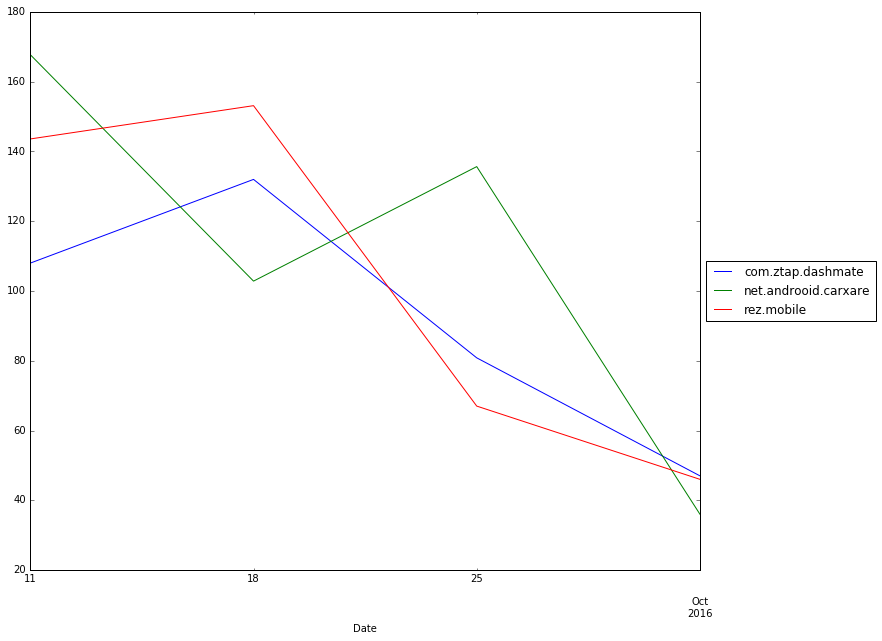

In [44]:
#all_ranking_data = displayer.getAllRankingData('FINANCE', 'topselling_paid')
all_ranking_data = displayer.getAllRankingData('TRANSPORTATION', 'topselling_paid')
#print all_ranking_data.tail()
#print all_ranking_data.coloumn

all_ranking_data_average_week = all_ranking_data.resample('w', 'mean')
print all_ranking_data_average_week.shape

#LOOK FOR APPS THAT HAVE A HUGE IMPROVEMENT IN RANKING FROM THE FIRST PART TO THE LAST PART
all_ranking_data_average_week = \
    all_ranking_data_average_week.ix[:,all_ranking_data_average_week[int(all_ranking_data_average_week.shape[0]/2):].min()<50]
all_ranking_data_average_week = \
    all_ranking_data_average_week.ix[:,all_ranking_data_average_week[:int(all_ranking_data_average_week.shape[0]/2)].mean()>100]
#all_ranking_data_average_week = all_ranking_data_average_week.ix[:,all_ranking_data_average_week[:int(all_ranking_data_average_week.shape[0]/2)].mean()<20]

print all_ranking_data_average_week.shape


all_ranking_data_average_week.plot()
ax = plt.gca()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.draw()

# Plot data for an individual app

In [ ]:
appid = "com.oxbowsoft.debtplanner"
#appid = "com.levelmoney.mobile"
#appid = "com.parabletechnologysystems.debtpayoffcalculator"
#appid = "com.zonewalker.acar.pro"
title = displayer.getTitle(appid)
(date,rank) = displayer.getRankLatest(appid, 'FINANCE', 'topselling_free')
print "The app %s is ranked %s on %s" % (title, rank, date)
ranking_json = displayer.getDailyInfo(appid, 'FINANCE', 'topselling_free')


ranking_data = pd.read_json(ranking_json)
ranking_data = ranking_data.rename(columns = {0:'Date'})
ranking_data = ranking_data.rename(columns = {1:'Ranking'})
ranking_data = ranking_data.rename(columns = {2:'Reviews'})
ranking_data = ranking_data.rename(columns = {3:'Rating'})

ranking_data['Date'] = ranking_data['Date'].apply(pd.to_datetime)
ranking_data['Reviews'] = ranking_data['Reviews'].convert_objects(convert_numeric=True)

ranking_data = ranking_data.set_index('Date')


try:
    ranking_data=ranking_data.replace(',', '')
    ranking_data['Reviews'] = ranking_data['Reviews'].str.replace(',', '').convert_objects(convert_numeric=True)
except:
    pass

#GET DATA FOR THE WEEK
ranking_data = ranking_data.resample('d', 'mean')

#PLOTTING
# create the general figure

ranking_data.Ranking.plot()
plt.title(appid, fontsize=16)
#ranking_data.Rating.plot()
plt.ylabel('Ranking', fontsize=16)
plt.legend()

ranking_data.Reviews.plot(secondary_y=True, style='g')
plt.ylabel('Reviews', fontsize=16)
#ranking_data.Rating.plot(secondary_y=True, style='g')
#plt.ylabel('Rating', fontsize=16)
plt.legend()
#savefig(appid+'.png')

In [ ]:
#sendEmail doesn't work, I think because of access permissions of the email itself

title = displayer.sendEmail(appid)

## Broken: Table of finance apps ranked by downloads


In [ ]:
apps = ['com.oxbowsoft.debtplanner','com.levelmoney.mobile']
comma = "','"
apps_csv = comma.join(apps)
apps_csv = "'"+apps_csv+"'"
print apps_csv
#for appid in apps:
app_reviews_json = displayer.getAppReviews(apps, 'FINANCE', 'topselling_free')
#all_reviews_json = displayer.getAllReviews('FINANCE', 'topselling_paid')
app_reviews_data = pd.read_json(app_reviews_json)

print app_reviews_data.head()
app_reviews_data = app_reviews_data.rename(columns = {1:'Date'})
app_reviews_data['Date'] = app_reviews_data['Date'].apply(pd.to_datetime)
#app_reviews_data = app_reviews_data.set_index('Date')
app_reviews_data = app_reviews_data.rename(columns = {0:'AppId'})
app_reviews_data = app_reviews_data.rename(columns = {2:'Reviews'})
    
    
app_reviews_data=app_reviews_data.drop_duplicates(['Date']).pivot(index='Date', columns='AppId', values='Reviews')
print app_reviews_data.head()

#GET DATA FOR THE WEEK
app_reviews_data = app_reviews_data.resample('w', 'mean')

#PLOTTING
# create the general figure

app_reviews_data[appid].plot(secondary_y=True, style='g')
plt.ylabel('Reviews', fontsize=16)
#ranking_data.Rating.plot(secondary_y=True, style='g')
#plt.ylabel('Rating', fontsize=16)
plt.legend()
#savefig(appid+'.png')

# Table of finance apps ranked by downloads including word frequencies of descriptions


In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def word_freq(x):
    #words = nltk.tokenize.word_tokenize(x)
    custom_stopwords = ['app','use','new']
    stop_words = set(stopwords.words('english')+list(string.punctuation)+custom_stopwords)
    words = [i.lower() for i in nltk.tokenize.word_tokenize(x) if i.lower() not in stop_words]
    fdist = nltk.FreqDist(words)
    return fdist.most_common(10)
    
all_titles_json = displayer.getAllTitles()
all_titles = pd.read_json(all_titles_json)
all_titles = all_titles.rename(columns = {0:'AppId'})
all_titles = all_titles.rename(columns = {1:'Title'})

#all_titles = all_titles.set_index('AppId')
#print all_titles.head()

all_full_descriptions_json = displayer.getAllFullDescriptions()
all_full_descriptions = pd.read_json(all_full_descriptions_json)
all_full_descriptions = all_full_descriptions.rename(columns = {0:'AppId'})
all_full_descriptions = all_full_descriptions.rename(columns = {1:'FullDescription'})
all_full_descriptions['FullDescription'] = all_full_descriptions['FullDescription'].map(lambda x: x.lstrip('tabindex="0"> '))

all_full_descriptions['FullDescriptionWordFreq'] = all_full_descriptions['FullDescription'].apply(word_freq)



In [3]:
print all_full_descriptions.head()

                          AppId  \
0        com.creditkarma.mobile   
1         com.chase.sig.android   
2              com.infonow.bofa   
3       com.wf.wellsfargomobile   
4  com.paypal.android.p2pmobile   

                                     FullDescription  \
0  Credit Karma is the free, effortless way to st...   
1  Do your banking right from your Android™ devic...   
2  Bank conveniently and securely with Bank of Am...   
3  Wells Fargo Mobile® is a fast, secure, and fre...   
4  Pay Smarter. Pay Simpler. Pay Anywhere. The wo...   

                             FullDescriptionWordFreq  
0  [(credit, 25), (scores, 5), (karma, 5), (trans...  
1  [(chase, 14), (view, 6), (•, 6), (account, 6),...  
2  [(bank, 9), (america, 8), (transfers, 7), (acc...  
3  [(fargo, 17), (wells, 15), (mobile, 7), (advis...  
4  [(pay, 5), (stores, 3), (paypal, 2), (online, ...  


# Get the number of reviews for each day

In [43]:
rows_to_fetch = 1000
cutoff = 500
category = 'FINANCE'
category = 'TRANSPORTATION'
collection = 'topselling_paid'

all_reviews_data = displayer.getAllReviewsData(category, collection, cutoff, rows_to_fetch)

#print all_reviews_data.head()
#all_reviews_data = all_reviews_data.set_index('AppId')

all_reviews_verbose_data = pd.merge(all_titles, all_reviews_data)
all_reviews_verbose_data = pd.merge(all_reviews_verbose_data, all_full_descriptions)
#all_reviews_verbose_data['Reviews'] = all_reviews_verbose_data['Reviews'].convert_objects(convert_numeric=True)
print all_reviews_verbose_data.shape

#GET RID OF UNICODE
types = all_reviews_verbose_data.apply(lambda x: pd.lib.infer_dtype(x.values))
try:
    for col in types[types=='unicode'].index:
        #all_reviews_verbose_data[col] = all_reviews_verbose_data[col].astype(str)
        all_reviews_verbose_data[col] = all_reviews_verbose_data[col].apply(lambda x: x.encode('utf-8').strip())
except:
    pass

#all_reviews_verbose_data = all_reviews_verbose_data.sort_values(by='Reviews', ascending=False).drop_duplicates(subset='AppId')
all_reviews_verbose_data.head(20)

(0, 10)


,AppId,Title,Date,Reviews,FullDescription,FullDescriptionWordFreq,ReviewsDiff,Reviews_x,Reviews_y,LDATopic1


In [34]:
all_reviews_verbose_data['Reviews'] = all_reviews_verbose_data['Reviews'].convert_objects(convert_numeric=True)

#print [all_reviews_verbose_data.iloc[:,i].apply(type).value_counts() for i in range(all_reviews_verbose_data.shape[1])]
#file_name = 'all_reviews_verbose_data.csv'

#all_reviews_verbose_data.to_csv(file_name, sep=',', encoding='utf-8')
#all_reviews_verbose_data.sort_values(['AppId','Date'],ascending=True)\
#    .set_index(['AppId','Date']).groupby(level=0).diff().head(200)
all_reviews_verbose_data['Date'] = pd.to_datetime(all_reviews_verbose_data['Date'])
all_reviews_verbose_data['Reviews'] = pd.to_numeric(all_reviews_verbose_data['Reviews']).astype('float64')
all_reviews_verbose_data['AppId']=all_reviews_verbose_data['AppId'].astype(str)



xxx = all_reviews_verbose_data.sort_values(['AppId','Date'],ascending=True)\
    .set_index(['AppId','Date'])
review_difference_per_day = xxx['Reviews'].groupby(level=0).diff().mean(level=0).sort_values(ascending=False)
#print review_difference_per_day
all_full_descriptions['ReviewsDiff']=review_difference_per_day
all_reviews_verbose_data_with_difference = all_reviews_verbose_data.merge(review_difference_per_day.to_frame(), left_on='AppId', right_index=True)
all_full_descriptions = all_full_descriptions.merge(review_difference_per_day.to_frame(), left_on='AppId', right_index=True)

#all_reviews_verbose_data_with_difference = pd.merge(review_difference_per_day, all_reviews_verbose_data.sort_values(ascending=False))
#print review_difference_per_dayF
print all_full_descriptions.sort_values('ReviewsDiff', ascending=False).head(10)

#print all_reviews_verbose_data.head()
#all_full_descriptions["ReviewsDiff"] = np.nan
if 0:
    stop=0
    for title, new_df in xxx:
        stop+=1
        print new_df
        print("%s %s %s" % (new_df.Title.drop_duplicates().values[0],new_df.index.values,new_df.Reviews.diff().mean()))
        #all_reviews_verbose_data['Reviews']
        all_full_descriptions.loc[new_df.index.values[0]]['ReviewsDiff']=new_df.Reviews.diff().mean()
        if stop > 10:
            break

                                    AppId  \
724                     com.onetwoapps.mh   
725           air.com.tornscreen.cfgame01   
726  com.inadaydevelopment.cashcalculator   
731                    com.monefy.app.pro   
732            com.anishu.homebudget.full   
733                  com.molovi.checkbook   
734    com.hoeksoft.minute.widget.verizon   
735            com.w2cyk.balance4eppicard   
736          com.roaddogssoftware.cardapp   
737                          com.hp.hp12c   

                                       FullDescription  \
724  My Budget Book helps you to keep track of your...   
725  Craft your financial strategy to get out of th...   
726  In-App Upgrade: 10bii+ Features (Bonds, Breake...   
731  How to track your expenses successfully? We kn...   
732  Now available in mobile [Android, iPhone/iPad]...   
733  **IMPORTANT!!!!  If an issue is not reported t...   
734  ONLY COMPATIBLE WITH VERIZON WIRELESS -- IF YO...   
735  Save time with the only mobile app 

/Users/chris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


# Topic Model for Description

In [26]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
nltk.download('wordnet')
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in all_full_descriptions['FullDescription']] 

[nltk_data] Downloading package wordnet to /Users/chris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=25, id2word = dictionary, passes=50)


In [29]:
for topic in ldamodel.print_topics(num_topics=25, num_words=3):
    print topic 

(0, u'0.012*tip + 0.012*bill + 0.010*app')
(1, u'0.048*chart + 0.039*stock + 0.036*price')
(2, u'0.012*app + 0.012*cost + 0.011*fuel')
(3, u'0.036*stock + 0.025*\u25a0 + 0.013*date')
(4, u'0.013*moneywiz + 0.012*paycheck + 0.010*rate')
(5, u'0.030*silver + 0.028*gold + 0.021*price')
(6, u'0.029*account + 0.026*expense + 0.024*budget')
(7, u'0.019*accounting + 0.018*exam + 0.013*financial')
(8, u'0.012*check + 0.009*widget + 0.008*account')
(9, u'0.013*tip + 0.012*retirement + 0.011*app')
(10, u'0.018*gold + 0.017*forex + 0.017*screener')
(11, u'0.011*tip + 0.010*checkbook + 0.008*display')
(12, u'0.026*financial + 0.021*calculator + 0.014*value')
(13, u'0.017*number + 0.010*time + 0.008*game')
(14, u'0.012*desktop + 0.011*app + 0.010*use')
(15, u'0.037*\u2714 + 0.013*using + 0.013*delivery')
(16, u'0.069*calculator + 0.014*calculation + 0.012*tape')
(17, u'0.022*app + 0.012*email + 0.011*tax')
(18, u'0.016*app + 0.011*und + 0.011*\u2013')
(19, u'0.031*payment + 0.030*loan + 0.019*calcu

In [33]:
print len(doc_term_matrix)

147


In [35]:
#all_reviews_data.set_index.sort_values(['AppId','Date']).(['AppId','Date']).diff()
#all_reviews_data.sort_values(['AppId','Date'],ascending=False).set_index(['AppId','Date']).diff()
#review_difference_per_day= all_reviews_data_verbose.sort_values(['AppId','Date'],ascending=True)\
#    .set_index(['AppId','Date']).groupby(level=0).diff().mean(level=0)
    
    


#print review_difference_per_day.head(100)
#review_difference_per_day = review_difference_per_day.rename(columns = {'Reviews':'ReviewsDiff'}).reset_index()
#print review_difference_per_day.head(100)
#all_reviews_data2 = all_reviews_data.set_index(['AppId','Date'])
#print all_reviews_data.head()

#all_reviews_verbose_data_with_difference = pd.merge(review_difference_per_day, all_reviews_verbose_data)

#new_columns = all_reviews_verbose_data_with_difference.columns.values
#new_columns[1] = 'ReviewsDiff'
#all_reviews_verbose_data_with_difference.columns = new_columns


#all_reviews_verbose_data_with_difference = all_reviews_verbose_data_with_difference.sort_values(by='ReviewsDiff',ascending=False)
#all_reviews_verbose_data_with_difference.ix[:,all_reviews_verbose_data_with_difference['ReviewsDiff']!=np.nan].\
#    sort_values(by='ReviewsDiff',ascending=False).drop_duplicates(subset=['AppId'], keep=False)
#all_reviews_verbose_data_with_difference
all_reviews_verbose_data_with_difference=all_reviews_verbose_data_with_difference.set_index('AppId')
all_reviews_verbose_data_with_difference["LDATopic1"] = np.nan
print all_reviews_verbose_data_with_difference.head()

ValueError: can not merge DataFrame with instance of type <class 'pandas.core.series.Series'>

# Apply the LDA and Merge with ReviewsDiff

In [36]:



i=0
for appid,df in all_full_descriptions.iterrows():
    print i
    i=1+i
    if i>10:
        break
    
    try:
        print(appid)
        print('X')
        full_description = df['FullDescription'].encode('utf-8').strip()
        print(full_description)
        doc_clean = clean(full_description).split()
        # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
        doc_term_matrix = dictionary.doc2bow(doc_clean)
        topic =ldamodel[doc_term_matrix]
        print(topic)
        # print the document's single most prominent LDA topic
        lda_result = str(ldamodel.print_topic(max(topic, key=lambda item: item[1])[0]))
        print("AppId = %s, Topic = %s, FullDescription = %s" % (appid,lda_result,full_description))
        all_full_descriptions[appid] = all_full_descriptions.set_value(appid,'LDATopic1',lda_result)
        print(all_full_descriptions[appid])
        #print(df[appid])


        print("Doing %s" % appid)
    except:
        #print full_description
        #print("Skipping %s" % appid)
        i = i-1
        pass


    
#all_reviews_verbose_data_with_difference_lda = pd.merge(review_difference_per_day, all_reviews_verbose_data)

0
724
X
My Budget Book helps you to keep track of your expenses and income, and helps you manage your money more effectively.Use the individual transactions and recurring transactions feature to get an idea of your expenses over the next couple of months and see how much money you have available to spend. The app also gives you a graphical overview of the information, making it easier to plan (larger) purchases over the upcoming months.The budget mode allows you to set various goals and for certain periods of time. For example, you can use the feature to create a monthly limit for refueling or a weekly limit for food. You can also define limits for accounts such as credit cards or other types of payment. Furthermore, the app can help you determine whether recurring budgets should be transferred to the next period.Main features:• Offline availability. For security reasons, the app has no internet permission.• No advertising and no hidden in-app costs.• Configurable Material Design layou

In [39]:
print all_full_descriptions['LDATopic1'].head(20)
all_full_descriptions.to_csv(category+'_'+collection+'_.csv', sep=',', encoding='utf-8')

724                                                  NaN
725                                                  NaN
726    0.026*financial + 0.021*calculator + 0.014*val...
731                                                  NaN
732                                                  NaN
733                                                  NaN
734    0.012*check + 0.009*widget + 0.008*account + 0...
735                                                  NaN
736    0.016*widget + 0.010*card + 0.008*database + 0...
737                                                  NaN
738                                                  NaN
739    0.022*app + 0.012*email + 0.011*tax + 0.010*bu...
740    0.012*desktop + 0.011*app + 0.010*use + 0.010*...
741                                                  NaN
742    0.029*account + 0.026*expense + 0.024*budget +...
743                                                  NaN
744    0.031*payment + 0.030*loan + 0.019*calculator ...
745                            

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

token_dict = {}
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

custom_stopwords = ['app','use','new']
stop_words = set(stopwords.words('english')+list(string.punctuation)+custom_stopwords)

for full_description in all_reviews_verbose_data_with_difference['FullDescription']:
    lowers = full_description.lower()
    
    remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
    word_list = [s.translate(remove_punctuation_map) for s in full_description]

    stop_words = set(stopwords.words('english')+list(string.punctuation)+custom_stopwords)
    words = [i.lower() for i in nltk.tokenize.word_tokenize(full_description) if i.lower() not in stop_words]
    
    #no_punctuation = lowers.translate(None, string.punctuation)
    token_dict[file] = words

In [ ]:
#this can take some time
# TRAIN THE MODEL BASED ON THE WHOLE CORPUS
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words)
tfs = tfidf.fit_transform(all_reviews_verbose_data_with_difference['FullDescription'])

In [ ]:
#RUN THE MODEL ON SOMETHING NEW
#appid = "com.oxbowsoft.debtplanner"
all_full_descriptions["TFIDF"] = np.nan
j=0
for index_appid, row_appid in all_full_descriptions.iterrows():
    
    #print row_appid
    appid = row_appid['AppId']
    
    #print all_full_descriptions.head()
    all_full_descriptions['FullDescription']
    appid_full_description = all_full_descriptions.loc[all_full_descriptions['AppId'] == appid].values[0]

    #print appid_full_description[1]
    response = tfidf.transform([appid_full_description[1]])
    #print type(response)
    
    #print all_full_descriptions.head()
    #

    feature_names = tfidf.get_feature_names()
    tfidf_df = pd.DataFrame({'word' : [], 'tfidf' : []})

    i=0
    for col in response.nonzero()[1]:
        tfidf_df.loc[i] = [response[0, col],feature_names[col]]
        #print feature_names[col], ' - ', response[0, col]
        i+=1
    #print tfidf_df.sort_values(by='tfidf', ascending=False).head(10)
    i=0
    tfidf_string = ""
    for index, row in tfidf_df.sort_values(by='tfidf', ascending=False).iterrows():
        if i>10:
            break
        tfidf_string=tfidf_string+row['word']+"("+str(round(row['tfidf'],2))+"), "
        i+=1


    all_full_descriptions['TFIDF'].loc[all_full_descriptions['AppId'] == appid] = tfidf_string
    j+=1
    #if j>100:
    #    break
#print_full(all_reviews_verbose_data['AppId'].loc[all_reviews_verbose_data['TFIDF'] != NULL])
#print_full(all_reviews_verbose_data['AppId'])

In [ ]:
all_full_descriptions

In [ ]:
#all_reviews_verbose_data_with_difference

#all_reviews_verbose_data_with_difference = all_reviews_verbose_data_with_difference.reset_index()
#all_full_descriptions = all_full_descriptions.reset_index()


if 'level_0' in all_reviews_verbose_data_with_difference.columns:
    all_reviews_verbose_data_with_difference = all_reviews_verbose_data_with_difference.drop('level_0', 1)

print all_reviews_verbose_data_with_difference.head()
print all_full_descriptions.head()

complete_data = pd.merge(all_reviews_verbose_data_with_difference, all_full_descriptions, on='AppId', how='inner')

In [ ]:
complete_data = complete_data.sort_values(by='ReviewsDiff',ascending=False)
#all_reviews_verbose_data_with_difference.ix[:,all_reviews_verbose_data_with_difference['ReviewsDiff']!=np.nan].\
#    sort_values(by='ReviewsDiff',ascending=False).drop_duplicates(subset=['AppId'], keep=False)
complete_data

In [ ]:
complete_data.to_csv('/Users/chris/Documents/workspace/cgi-bin/PlayScraper/reviews.csv', sep=',', encoding='utf-8')